In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.preprocessing import PolynomialFeatures
from numpy import polyfit
from collections import Counter
from collections import namedtuple
import PIL
from PIL import Image

from lookup_table import LUT

In [2]:
from mapping import get_fwd_mapping_H,get_bwd_mapping_H

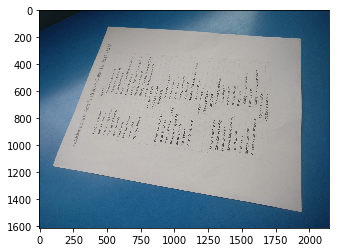

In [3]:
source_image=cv2.imread("./photo.jpg")
plt.imshow(source_image)

In [4]:
x_coords = [1946,105,511,1944]
y_coords = [1499,1159,125,217]# Plot points from the previous problem is used to draw over your image
# Note that your coordinates will change once you resize your image again
source_points = np.vstack((x_coords, y_coords))

In [5]:
def to_homog(points): #here always remember that points is a 3x4 matrix
   # write your code here
    if len(points.shape)==1:
       # only 1 point is passed:
        a=np.ones((len(points)+1),np.float32)
        a[0]=points[0]
        a[1]=points[1]
        return a
    r,c=(points.shape[0]+1,points.shape[1])
    a=np.ones((r,c),type(points[0,0]))
    a[:r-1,:]=points[:,:]
    return a# convert points from homogeneous to euclidian
def from_homog(points_homog):
   # write your code here
    if len(points_homog.shape)==1:
       # only 1 point is passed:
        a=np.zeros((len(points_homog)-1),np.float32)
        a[0]=points_homog[0]/points_homog[2]
        a[1]=points_homog[1]/points_homog[2]
        return a
    n=points_homog.shape[0]-1
    m=points_homog.shape[1]
    b=np.zeros((n,m),np.float32)
    for i in range(n):
        b[i,:]=points_homog[i,:]/points_homog[n,:]    
    return b# project 3D euclidian points to 2D euclidian
def project_points(P_int, P_ext, pts):
   # write your code here
   # assuming P_int is the camera matrix (3x4)
   # P_ext is 4x4
   # pts are 3x1 (non homogenous)
    print(np.shape(P_int))
    print(np.shape(P_ext))
    print(np.shape(to_homog(pts)))
    pts_final=np.matmul(P_int,np.matmul(P_ext,to_homog(pts)))
    return from_homog(pts_final)

In [6]:
def computeH(source_points, target_points):
    # returns the 3x3 homography matrix such that:
    # np.matmul(H, source_points) = target_points
    # where source_points and target_points are expected to be in homogeneous
    # make sure points are 3D homogeneous
    assert source_points.shape[0]==3 and target_points.shape[0]==3
    #Your code goes here
    H_mtx = np.zeros((3,3)) #Fill in the H_mtx with appropriate values.
    #source to e -> H1, e to target -> H2_inv
    # will calculate H1, and H2. Then do H1.H2^-1
    # H1
    xin=source_points.T
    print("XIN",xin)
    xinmat=np.hstack((xin[0,:].reshape(-1,1),xin[1,:].reshape(-1,1),xin[2,:].reshape(-1,1)))
    print("XINMAT",xinmat)
    lambdas1=np.matmul(np.linalg.inv(xinmat),xin[3,:].reshape(-1,1)).reshape(-1)    
    print("LAMBDAS1",lambdas1)
    H1inv=np.hstack((xin[0,:].reshape(-1,1)*lambdas1[0],
                    xin[1,:].reshape(-1,1)*lambdas1[1],
                    xin[2,:].reshape(-1,1)*lambdas1[2]))
    print("H1inv",H1inv)
    xout=target_points.T
    print("XOUT",xout)
    xoutmat=np.hstack((xout[0,:].reshape(-1,1),xout[1,:].reshape(-1,1),xout[2,:].reshape(-1,1)))
    print("XOUTMAT",xoutmat)
    lambdas2=np.matmul(np.linalg.inv(xoutmat),xout[3,:].reshape(-1,1)).reshape(-1)
    print("LAMBDAS2",lambdas2)
    H2inv=np.hstack((xout[0,:].reshape(-1,1)*lambdas2[0],
                   xout[1,:].reshape(-1,1)*lambdas2[1],
                   xout[2,:].reshape(-1,1)*lambdas2[2]))
    print("H2inv",H2inv)
    H_mtx=np.matmul(H2inv,np.linalg.inv(H1inv))
    print("***********")
    return  H_mtx

In [37]:
def distance(x1,y1,x2,y2,metric='l1'):
    if metric=='l1':
        return np.abs(x1-x2)+np.abs(y1-y2)
    if metric=='l2':
        return np.sqrt((x1-x2)**2+(y1-y2)**2)

def n_nearest_neighbours(x,y,n=8,dist='l2'):
    '''Takes a point in 2D space,
    returns n nearest neighbours (n<=15)
    '''
    nn=[]
    fracx=x%1.0
    fracy=y%1.0
    xfloor=np.floor(x)
    yfloor=np.floor(y)
    xceil=np.ceil(x)
    yceil=np.ceil(y)
    window_size=int(np.ceil(np.sqrt(n)))
    xns=set(range(int(xfloor)-int(window_size/2),int(xceil)+int(window_size/2)+1))
    yns=set(range(int(yfloor)-int(window_size/2),int(yceil)+int(window_size/2)+1))
#     xns=set([xfloor-2,xfloor-1,xfloor,xceil,xceil+1,xfloor+2])
#     yns=set([yfloor-1,yfloor,yceil,yceil+1])
        
    for xn in xns:
        for yn in yns:
            a=distance(x,y,xn,yn,metric='l2')
#             print(type(a))
#             print(type(xn))
#             print(type(yn))
            nn.append((a,xn,yn))
#     nn=sorted(nn)
#     return nn[:n]
    return nn

In [7]:
def warp(source_img, source_points, target_size):
    
    assert target_size[2]==source_img.shape[2]
    h=target_size[0]-1#nrows
    w=target_size[1]-1#ncols
    
    target_points_xy=np.asarray([[0,h],[0.0,0.0],[w,0],[w,h]]).T
    
    target_img=np.zeros(target_size)
    secondary_buffer=np.zeros(target_size[:2])
    for pts in target_points:
        print(target_img[int(pts[1]),int(pts[0])])
    print("Source Points",source_points)
    print("Target Points",target_points)
    H=computeH(to_homog(source_points),to_homog(target_points))
    for pts in source_points.T:
        homogpts=to_homog(pts)
        print("Source Point:",pts)
        outpts=from_homog(np.matmul(H,homogpts))
        print("Corresponding Output point",(int(outpts[0]),int(outpts[1])))
    jo_arr=[]
    io_arr=[]
    for j in range(3,source_img.shape[0]-3):
        for i in range(3,source_img.shape[1]-3):
            inpts=to_homog(np.asarray([j,i]))            
            (jo,io)=from_homog(np.matmul(H,inpts))
            if io<0 or io>=target_img.shape[0] or jo<0 or jo>=target_img.shape[1]:
                continue
            nbrs=n_nearest_neighbours(outpts[0],outpts[1],n=15,dist='l2')
            intensity=source_img[i,j,:]
            for nbr in nbrs:
                if len(nbr)!=3:
                    print(nbr)
                    continue
                if nbr[0]==0.0:
                    target_img[int(nbr[2]),int(nbr[1])]+=intensity    
                else:
                    target_img[int(nbr[2]),int(nbr[1])]+=intensity/nbr[0]
                secondary_buffer[int(nbr[2]),int(nbr[1])]+=1
    for i in range(source_img.shape[0]):
        for j in range(source_img.shape[1]):
            if secondary_buffer[i,j]!=0:
                target_img[i,j]/=secondary_buffer[i,j]
    return target_img# Use the code below to plot your result
    # source_points=np.asarray([[105.0,115.0],[50.0,10.0],[195.0,19.0],[195.0,150.0]]).T.astype(np.float32)
    # print("Source Points:",source_points)
    # print(source_image.shape)

In [ ]:
def forward_mapping_with_nearest_nbrs(source_img, source_points, target_size):
    # Create a target image and select target points to create a homography from source image to target image,
    # in other words map all source points to target points and then create
    # a warped version of the image based on the homography by filling in the target image.
    # Make sure the new image (of size target_size) has the same number of color channels as source image
    assert target_size[2]==source_img.shape[2]
    #Your code goes here
#     target_size=(int(target_size[0]/2),int(target_size[1]/2),target_size[2])
#     target_size[1]/=2.0
    h=target_size[0]-1#nrows (max for i)
    w=target_size[1]-1#ncols (max for j)
    print("h,w:",h,w)
    target_points_xy=np.asarray([[0,h],[0.0,0.0],[w,0],[w,h]]).T
    target_img=np.zeros(target_size)
    secondary_buffer=np.zeros(target_size[:2])
    for pts in target_points_xy.T:
        print(pts,target_img[int(pts[1]),int(pts[0])])

    print("Source Points coordinates:",source_points)
    print("Target Points coordinates:",target_points_xy)
    H=computeH(to_homog(source_points),to_homog(target_points_xy))
    for pts in source_points.T:
        homogpts=to_homog(pts)
        print("Source Point coordinates:",pts)
        outpts=from_homog(np.matmul(H,homogpts))
        print("Corresponding Output point coordinates",(int(outpts[0]),int(outpts[1])))
    for xin in range(source_img.shape[1]):
        for yin in range(source_img.shape[0]):
            inpts=to_homog(np.asarray([xin,yin]))
            
            (x,y)=from_homog(np.matmul(H,inpts))
            
            
            if x<4 or x>target_img.shape[1]-4 or y<4 or y>target_img.shape[0]-4:
                continue
                
            
                
            nbrs=n_nearest_neighbours(y,x,n=1,dist='l2')
            intensity=source_img[yin,xin,:]
            for nbr in nbrs:
                if len(nbr)!=3:
                    print(nbr)
                    continue
#                 if nbr[0]==0.0:
#                     target_img[int(nbr[1]),int(nbr[2])]+=intensity    
#                     secondary_buffer[int(nbr[1]),int(nbr[2])]+=1
                if nbr[1]<0 or nbr[1]>=target_img.shape[0] or nbr[0]<0 or nbr[0]>=target_img.shape[1]:
                    print(nbr)
                    print(x,y)
                    print(xin,yin)
                else:
#                     target_img[int(nbr[1]),int(nbr[2])]+=intensity
#                     print("***************")
#                     print(target_img[int(nbr[1]),int(nbr[2])])
#                     print(intensity)
#                     print(np.exp(-1*nbr[0]))
#                     print("++++++++++++++++++++")
                    target_img[int(nbr[1]),int(nbr[2])]+=intensity*np.exp(-1*nbr[0])
                        
#                         target_img[int(nbr[1]),int(nbr[2])]+=intensity/nbr[0]
                    secondary_buffer[int(nbr[1]),int(nbr[2])]+=np.exp(-1*nbr[0])
                
    for yin in range(target_img.shape[0]):
        for xin in range(target_img.shape[1]):
            if secondary_buffer[yin,xin]!=0:
                target_img[yin,xin,:]/=secondary_buffer[yin,xin]
                print("(((((((((((((((((((((((((((((((((")
                print(target_img[yin,xin,:])
                print(secondary_buffer[yin,xin])
                print("))))))))))))))))))))))))))))))))))")
#             target_img[int(y),int(x),:]=source_img[yin,xin,:]
    return target_img

# Use the code below to plot your result
# source_points=np.asarray([[105.0,115.0],[50.0,10.0],[195.0,19.0],[195.0,150.0]]).T.astype(np.float32)
# print("Source Points:",source_points)
# print(source_image.shape)
result = forward_mapping_with_nearest_nbrs(source_image, source_points, (source_image.shape[1],source_image.shape[0],3)) #Choose appropriate target size
result/=255.0
plt.subplot(1, 2, 1)
plt.imshow(source_image)
plt.subplot(1, 2, 2)
plt.imsave("fwd_mapping_1nn_exp_decay_weigh_by_exp.png",result)
plt.imshow(result)
plt.show()

In [9]:
fwd_mapped_image=cv2.imread('fwd_mapping_8nn_exp_decay_weigh_by_exp.png')
bwd_mapped_image=cv2.imread('backward_mapping.png')
assert fwd_mapped_image.shape == bwd_mapped_image.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


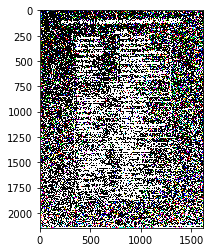

In [10]:
diff1=np.zeros(fwd_mapped_image.shape)
diff1[:,:,:]=bwd_mapped_image[:,:,:]-fwd_mapped_image[:,:,:]
plt.imsave("fwd_bwd_diff2.png",diff1)
plt.imshow(diff1)
plt.show()

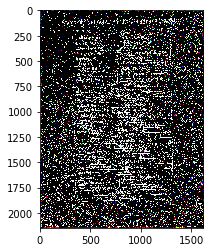

In [13]:
diff_norm=norm(diff1)
plt.imsave("bwd-fwd_diff_normed2.png",diff_norm)
plt.imshow(diff_norm)
plt.show()

(2148, 1611)


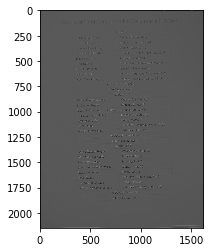

In [14]:
import matplotlib.cm as cm
import pylab as p
fwd_mapped_image_bw=norm(cv2.cvtColor(fwd_mapped_image,cv2.COLOR_RGB2GRAY))
bwd_mapped_image_bw=norm(cv2.cvtColor(bwd_mapped_image,cv2.COLOR_RGB2GRAY))

diff_grayscale=np.zeros(np.shape(fwd_mapped_image_bw))
diff_grayscale[:,:]=bwd_mapped_image_bw[:,:]-fwd_mapped_image_bw[:,:]
diff_grayscale_normed=norm(diff_grayscale)
print(diff_grayscale_normed.shape)
# p.figimage(diff_grayscale_normed,cmap=cm.Greys_r)
# p.savefig('diff_grayscale_normed2.png')
plt.imsave("diff_grayscale_normed2.png",diff_grayscale_normed,cmap='gray')
plt.imshow(diff_grayscale_normed,cmap='gray')

In [ ]:
i=cv2.imread('diff_grayscale_normed.png')
print(i.shape)

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(source_image)
plt.subplot(1, 2, 2)
plt.imsave("myop5.png",result)
plt.imshow(result)
plt.show()

In [8]:
def norm(img):
#    assert img.shape[2]==3
    maxi=img.max()
    mini=img.min()
    return (img-mini)/(maxi-mini)

In [ ]:
# import os
# for files in os.listdir("./"):
#     if "png" in files:
#         print(files)
image_in=cv2.imread('./fwd_mappin.png')
img2=norm(image_in)
plt.imsave("fwd_mapping_35nn_exp_decay_normalised.png",img2)
plt.imshow(img2)
plt.show()

In [ ]:
img1=cv2.imread("./fwd_mapping_1nn_no_bleeding.png")
img1_1=norm(img1)
img2=cv2.imread("./fwd_mapping_8nn_exp_decay_normalised.png")
img2_1=norm(img2)
img3=np.zeros(img1.shape)
img3[:,:,:]=(img2_1[:,:,:]-img1_1[:,:,:])

In [ ]:
# plt.imshow(img3)
# plt.show()
plt.imsave('diff.png',img3)
img3_1=norm(img3)
plt.imshow(img3_1)
plt.show()
plt.imsave('diff_normalised.png',img3_1)

[[1946  105  511 1944]
 [1499 1159  125  217]]
[[1946  105  511 1944]
 [1499 1159  125  217]]
XIN [[0.000e+00 2.148e+03 1.000e+00]
 [0.000e+00 0.000e+00 1.000e+00]
 [1.611e+03 0.000e+00 1.000e+00]
 [1.611e+03 2.148e+03 1.000e+00]]
XINMAT [[0.000e+00 0.000e+00 1.611e+03]
 [2.148e+03 0.000e+00 0.000e+00]
 [1.000e+00 1.000e+00 1.000e+00]]
LAMBDAS1 [ 1. -1.  1.]
H1inv [[ 0.000e+00 -0.000e+00  1.611e+03]
 [ 2.148e+03 -0.000e+00  0.000e+00]
 [ 1.000e+00 -1.000e+00  1.000e+00]]
XOUT [[1946 1499    1]
 [ 105 1159    1]
 [ 511  125    1]
 [1944  217    1]]
XOUTMAT [[1946  105  511]
 [1499 1159  125]
 [   1    1    1]]
LAMBDAS2 [ 0.74404815 -0.89973129  1.15568314]
H2inv [[ 1.44791770e+03 -9.44717858e+01  5.90554087e+02]
 [ 1.11532818e+03 -1.04278857e+03  1.44460393e+02]
 [ 7.44048150e-01 -8.99731294e-01  1.15568314e+00]]
***********
Source Point: [   0. 2148.]
Corresponding Output point [1946. 1499.]
Source Point: [0. 0.]
Corresponding Output point [ 105. 1159.]
Source Point: [1611.    0.]
Corr

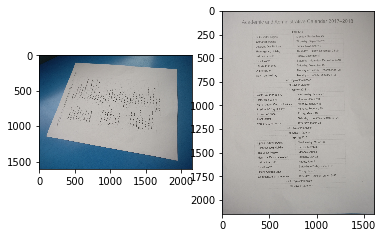

In [8]:
def warp2(source_img, source_points, target_size):
    # Create a target image and select target points to create a homography from target image to source image,
    # in other words map each target point to a source point, and then create a warped version
    # of the image based on the homography by filling in the target image.
    # Make sure the new image (of size target_size) has the same number of color channels as source image
    h=target_size[0]#nrows
    w=target_size[1]#ncols
    target_points_xy=np.asarray([[0,h],[0.0,0.0],[w,0],[w,h]]).T
    target_img=np.zeros(target_size)
    print(source_points)
    H=computeH(to_homog(target_points_xy),to_homog(source_points))
    for pts in target_points_xy.T:
        homogpts=to_homog(pts)
        print("Source Point:",pts)
        outpts=from_homog(np.matmul(H,homogpts))
        print("Corresponding Output point",outpts)

    for xin in range(target_img.shape[1]):
        for yin in range(target_img.shape[0]):
            inpts=to_homog(np.asarray([xin,yin]))
            
            (xout,yout)=from_homog(np.matmul(H,inpts))
            
            
            if xout<1 or xout>=source_img.shape[1]-1 or yout<1 or yout>=source_img.shape[0]-1:
                continue
            
            j,i=xout,yout
            fraci=i%1.0
            fracj=j%1.0
            intensity=(1-fraci)*(1-fracj)*source_img[int(np.floor(i))][int(np.floor(j))]+\
                        (fraci)*(1-fracj)*source_img[int(np.ceil(i))][int(np.floor(j))]+\
                        (fraci)*(fracj)*source_img[int(np.ceil(i))][int(np.ceil(j))]+\
                        (1-fraci)*(fracj)*source_img[int(np.floor(i))][int(np.ceil(j))]
                        
            target_img[yin,xin]=intensity
    return target_img
    #Your code goes here

# Use the code below to plot your result

print(source_points)
result = warp2(source_image, source_points, (source_image.shape[1],source_image.shape[0],3)) #Choose appropriate size
result/=255.0
plt.subplot(1, 2, 1)
plt.imshow(source_image)
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.imsave("backward_mapping.png",result)
plt.show()

In [9]:
H=get_fwd_mapping_H()

h,w: 1610 2147
[2147. 1610.] [0. 0. 0.]
[   0. 1610.] [0. 0. 0.]
[0. 0.] [0. 0. 0.]
[2147.    0.] [0. 0. 0.]
Source Points coordinates: [[1946  105  511 1944]
 [1499 1159  125  217]]
Target Points coordinates: [[2147.    0.    0. 2147.]
 [1610. 1610.    0.    0.]]
XIN [[1946 1499    1]
 [ 105 1159    1]
 [ 511  125    1]
 [1944  217    1]]
XINMAT [[1946  105  511]
 [1499 1159  125]
 [   1    1    1]]
LAMBDAS1 [ 0.74404815 -0.89973129  1.15568314]
H1inv [[ 1.44791770e+03 -9.44717858e+01  5.90554087e+02]
 [ 1.11532818e+03 -1.04278857e+03  1.44460393e+02]
 [ 7.44048150e-01 -8.99731294e-01  1.15568314e+00]]
XOUT [[2.147e+03 1.610e+03 1.000e+00]
 [0.000e+00 1.610e+03 1.000e+00]
 [0.000e+00 0.000e+00 1.000e+00]
 [2.147e+03 0.000e+00 1.000e+00]]
XOUTMAT [[2.147e+03 0.000e+00 0.000e+00]
 [1.610e+03 1.610e+03 0.000e+00]
 [1.000e+00 1.000e+00 1.000e+00]]
LAMBDAS2 [ 1. -1.  1.]
H2inv [[ 2.147e+03 -0.000e+00  0.000e+00]
 [ 1.610e+03 -1.610e+03  0.000e+00]
 [ 1.000e+00 -1.000e+00  1.000e+00]]
*****

In [10]:
source_image.shape

(1611, 2148, 3)

In [11]:
tables=LUT(H,source_image.shape)

-1032.7897 2422.374 -405.586 2092.6357


In [30]:
mapsx1=np.zeros(source_image.shape[:2])
mapsy1=np.zeros(source_image.shape[:2])
Hinv=np.linalg.inv(H)
for xin in range(source_image.shape[1]):
    for yin in range(source_image.shape[0]):
        xout,yout=from_homog(np.matmul(Hinv,to_homog(np.asarray([xin,yin]))))
        mapsx1[yin,xin]=xout
        mapsy1[yin,xin]=yout

(1611, 2148) (1611, 2148)


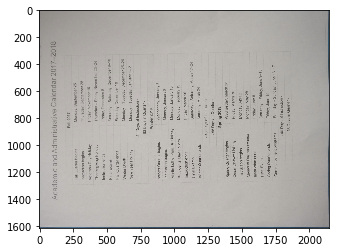

In [32]:
# mapsx,mapsy=tables.LUT_bwdf2(None,None)
mapsx1=mapsx1.astype(np.float32)
mapsy1=mapsy1.astype(np.float32)
print(mapsx1.shape,mapsy1.shape)
output_check=cv2.remap(source_image,mapsx1,mapsy1,cv2.INTER_LINEAR)
plt.imshow(output_check)
plt.show()

In [33]:
mapsx2=np.zeros(source_image.shape[:2])
mapsy2=np.zeros(source_image.shape[:2])
# Hinv=np.linalg.inv(H)
for xin in range(source_image.shape[1]):
    for yin in range(source_image.shape[0]):
        xout,yout=from_homog(np.matmul(H,to_homog(np.asarray([xin,yin]))))
        mapsx2[yin,xin]=xout
        mapsy2[yin,xin]=yout

(1611, 2148) (1611, 2148)


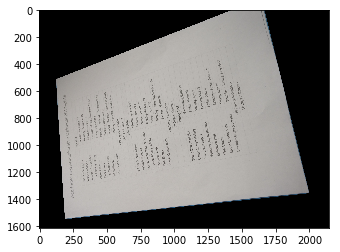

In [36]:
# mapsx,mapsy=tables.LUT_bwdf2(None,None)
mapsx2=mapsx2.astype(np.float32)
mapsy2=mapsy2.astype(np.float32)
print(mapsx2.shape,mapsy2.shape)
output_check2=cv2.remap(output_check,mapsx2,mapsy2,cv2.INTER_LINEAR)
plt.imshow(output_check2)
plt.show()

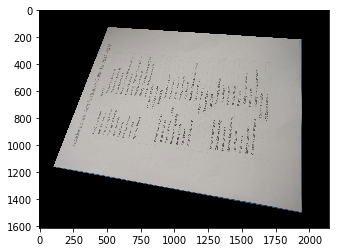

In [37]:
# output_check2=np.zeros(source_image.shape)
# # source_image_gray=
# output_check2=cv2.warpPerspective(source_image,H,(source_image.shape[1],source_image.shape[0]))
plt.imshow(output_check2)
plt.show()

In [12]:
def fwdf4(x,y,H):
    return from_homog(np.matmul(H,to_homog(np.asarray([x,y]))))

In [108]:
def LUT_fwdf2(i_in=None,j_in=None):
    '''Wrapper for the compressed forward-mapping LUT
    '''
    if i_in is None and j_in is None:
        return tables.LUT_fwd_x,tables.LUT_fwd_y
    elif i_in is None:
        return tables.LUT_fwd_x[:,j_in],tables.LUT_fwd_y[:,j_in]
    elif j_in is None:
        return tables.LUT_fwd_x[i_in,:],tables.LUT_fwd_y[i_in,:]
    else:
        xvals=[]
        yvals=[]
        i_in2=np.asarray(i_in).ravel()
        j_in2=np.asarray(j_in).ravel()
        #i_in, yd are arrays
        for yd1 in i_in2:
            for xd1 in j_in2:
                xcoeffs=tables.small_LUT_fwd_x[int(np.floor(xd1))]
                ycoeffs=tables.small_LUT_fwd_y[int(np.floor(yd1))]
                yvar=[yd1**p for p in range(tables.poly_degree,-1,-1)]
                xvar=[xd1**p for p in range(tables.poly_degree,-1,-1)]
                xval=np.dot(yvar,xcoeffs)
                yval=np.dot(xvar,ycoeffs)
                xvals.append(xval)
                yvals.append(yval)
        xvals=np.asarray(xvals)
        yvals=np.asarray(yvals)
        if len(i_in2)==1 and len(j_in2)==1:
            return xvals[0],yvals[0]
        else:
            return xvals,yvals

In [132]:
def LUT_fwdf2point(i_in,j_in):
    '''Wrapper for the compressed forward-mapping LUT, for single pixel input-outputs only (no arrays)
    '''
    xcoeffs=tables.small_LUT_fwd_x[int(np.floor(j_in))]
    ycoeffs=tables.small_LUT_fwd_y[int(np.floor(i_in))]
#     xvar=np.zeros(tables.poly_degree+1)
#     yvar=np.zeros(tables.poly_degree+1)
    xvar=1.0
    yvar=1.0
    xval=0.0
    yval=0.0
    for x in range(xcoeffs.shape[0]-1,-1,-1):
        xval+=xcoeffs[x]*yvar
        yval+=ycoeffs[x]*xvar
        xvar*=j_in
        yvar*=i_in
#     for p in range(tables.poly_degree,-1,-1):
#         xvar[tables.poly_degree-p]=np.power(i_in,p)
#         yvar[tables.poly_degree-p]=np.power(j_in,p)
#     yvar=[i_in**p for p in range(tables.poly_degree,-1,-1)]
#     xvar=[j_in**p for p in range(tables.poly_degree,-1,-1)]
#     xval=[i]
#     xval=yvar*xcoeffs
#     yval=xvar*ycoeffs
#     xval=np.dot(yvar,xcoeffs)
#     yval=np.dot(xvar,ycoeffs)
    return xval,yval

In [135]:
print(LUT_fwdf2point(0,0))
print(LUT_fwdf2(0,0))

(-1031.345127001597, -196.38736346156716)
(-1031.345127001597, -196.38736346156716)


In [109]:
import time
init_time=time.time()
for y in range(source_image.shape[0]):
    for x in range(source_image.shape[1]):
        xi,yi=LUT_fwdf2(y,x)
total_time=time.time()-init_time
print("LUT_fwdf2 takes: {} seconds".format(total_time)) 
init_time=time.time()
for y in range(source_image.shape[0]):
    for x in range(source_image.shape[1]):
        xi,yi=LUT_fwdf2point(y,x)
total_time=time.time()-init_time
print("LUT_fwdf2point takes: {} seconds".format(total_time)) 


LUT_fwdf2 takes: 150.1549937725067 seconds
LUT_fwdf2point takes: 80.00785660743713 seconds


In [124]:
import time
init_time=time.time()
for y in range(source_image.shape[0]):
    for x in range(source_image.shape[1]):
        xi,yi=LUT_fwdf2(y,x)
total_time=time.time()-init_time
print("LUT_fwdf2 takes: {} seconds".format(total_time)) 
init_time=time.time()
for y in range(source_image.shape[0]):
    for x in range(source_image.shape[1]):
        xi,yi=LUT_fwdf2point(y,x)
total_time=time.time()-init_time
print("LUT_fwdf2point takes: {} seconds".format(total_time)) 

LUT_fwdf2 takes: 152.20576667785645 seconds
LUT_fwdf2point takes: 42.57542848587036 seconds


In [91]:
# def f():
#     op_buffer_width=7
#     safe_interpolation_buffer_margin=3
#     output_buffer=np.zeros((source_image.shape[0],op_buffer_width,3))
#     secondary_buffer=np.zeros((source_image.shape[0],op_buffer_width))
#     input_buffer=np.zeros((source_image.shape))
#     output_image2=np.zeros((source_image.shape))
#     output_stream=[]
#     # output_buffer_rows=[]

#     minx=0
#     maxx=op_buffer_width-safe_interpolation_buffer_margin
#     output_buffer_offset=1
#     xoffset=tables.xrmin
#     yoffset=tables.yrmin

#     for yin in range(source_image.shape[0]):
#         row_touched=False
#         allmax=-1e6
#         allmin=1e6
#         for xin in range(source_image.shape[1]):
#             x,y=LUT_fwdf2(yin,xin)
#     #         x,y=fwdf4(xin,yin,H)
#             intensity=source_image[yin,xin]
#             x=x-xoffset
#             y=y-yoffset
#             allmin=min([allmin,x])
#             allmax=max([allmax,x])
#             if not(y>=0.0 and y<=float(source_image.shape[0])):#, (y,source_image.shape)
#                 continue
#             if x>=minx and x<=maxx:
#                 row_touched=True
#                 nbrs=n_nearest_neighbours(x,y,n=15,dist='l2')
#                 for nbr in nbrs:
# #                     if len(nbr)!=3:
# #                         print(nbr)
# #                         continue
#                     if nbr[1]<minx or nbr[1]>maxx or nbr[2]<0 or nbr[2]>=output_image2.shape[0]:
#     #                     input_buffer[nbr[1],nbr[0]]+=intensity
#                         continue
#                     else:
#                         output_buffer[int(nbr[2]),int(nbr[1])%op_buffer_width]+=intensity*np.exp(-1*nbr[0])
#                         secondary_buffer[int(nbr[2]),int(nbr[1])%op_buffer_width]+=np.exp(-1*nbr[0])
#                         output_image2[int(nbr[2]),int(nbr[1])]+=intensity*np.exp(-1*nbr[0])

#                     # flags[int(nbr[1]-minx+10*l)%l]=True
#             else:
#                 input_buffer[yin,xin]=intensity
#         print(allmin,allmax,minx,maxx)
#         if not row_touched:
#             '''   
#             this row was not touched. 
#             normalise and pop the rows till minx< allmin of that row
#             '''
#             while minx < allmin -1:
#                 print(minx)
#     #             temp_arr=np.divide()
#     #             output_stream.append(temp_arr)
#     #             output_image2[minx]=np.divide(output_image2[minx],secondary_buffer[minx%op_buffer_width])

#     #             for i in range(source_image.shape[1]):
#     #                 if secondary_buffer[minx%op_buffer_width,i] !=0:
#                 output_image2[:,minx,0]=np.nan_to_num(np.divide(output_image2[:,minx,0],secondary_buffer[:,minx%op_buffer_width]))
#                 output_buffer[:,minx%op_buffer_width,0]=np.nan_to_num(np.divide(output_buffer[:,minx%op_buffer_width,0],secondary_buffer[:,minx%op_buffer_width]))
#                 output_image2[:,minx,1]=np.nan_to_num(np.divide(output_image2[:,minx,1],secondary_buffer[:,minx%op_buffer_width]))
#                 output_buffer[:,minx%op_buffer_width,1]=np.nan_to_num(np.divide(output_buffer[:,minx%op_buffer_width,1],secondary_buffer[:,minx%op_buffer_width]))
#                 output_image2[:,minx,2]=np.nan_to_num(np.divide(output_image2[:,minx,2],secondary_buffer[:,minx%op_buffer_width]))
#                 output_buffer[:,minx%op_buffer_width,2]=np.nan_to_num(np.divide(output_buffer[:,minx%op_buffer_width,2],secondary_buffer[:,minx%op_buffer_width]))

#                 output_stream.append(output_buffer[:,minx%op_buffer_width])
#                 output_buffer[:,minx%op_buffer_width]=0
#                 secondary_buffer[:,minx%op_buffer_width]=0
#                 minx+=1
#                 maxx+=1
#                 '''            
#                 now that we have shifted rows up, look at the input buffer and put in pixels which can be put in
#                 '''
# #                 print("range of ix: {}-{}".format(list(range(source_image.shape[1]))[0],list(range(source_image.shape[1]))[-1]))
# #                 print("range of iy: {}-{}".format(list(range(source_image.shape[0]))[0],list(range(source_image.shape[0]))[-1]))
#                 for ix in range(source_image.shape[1]):
#                     for iy in range(source_image.shape[0]):
#                         if input_buffer[iy,ix,0]==0 and input_buffer[iy,ix,1]==0 and input_buffer[iy,ix,2]==0:
#                             continue
#                         #                     x,y=tables.LUT_fwdf3(iy,ix)
#                         x,y=LUT_fwdf2(iy,ix)
#                         intensity=input_buffer[iy,ix]
#                         x=x-xoffset
#                         y=y-yoffset
#                         assert x>=minx, (x,minx)
#                         if x<=maxx:
#                         #                         output_buffer[int(x)%l,int(y)]=intensity
#                         #                         input_buffer[ix,iy,:]=0
#                             nbrs=n_nearest_neighbours(x,y,n=15,dist='l2')
#                             for nbr in nbrs:
# #                                 if len(nbr)!=3:
# #                                     print(nbr)
# #                                     continue
#                                 if nbr[1]<minx or nbr[1]>maxx or nbr[2]<0 or nbr[2]>=output_image2.shape[0]:
#                                     continue
#                                 else:
#                                     output_buffer[int(nbr[2]),int(nbr[1])%op_buffer_width]+=intensity*np.exp(-1*nbr[0])
#                                     secondary_buffer[int(nbr[2]),int(nbr[1])%op_buffer_width]+=np.exp(-1*nbr[0])
#                                     output_image2[int(nbr[2]),int(nbr[1])]+=intensity*np.exp(-1*nbr[0])
#                                 input_buffer[iy,ix,:]=0
#                         #                             flags[int(nbr[1]+10*l)%l]=True
#                         else:
#                             continue
# #                 return None,None,None
#     return secondary_buffer,output_image2,output_stream

In [136]:
# op_buffer_width=4
# ncols_output=source_image.shape[1]
# nrows_output=1080
# output_buffer=np.zeros(op_buffer_width,ncols_output,3)
# secondary_buffer=np.zeros(op_buffer_width,ncols_output)

# for xin in range(source_img.shape[1]):
#     for yin in range(source_img.shape[0]):
# #         inpts=to_homog(np.asarray([xin,yin]))
# #         (x,y)=from_homog(np.matmul(H,inpts))
#         if x<4 or x>target_img.shape[1]-4 or y<4 or y>target_img.shape[0]-4:
#             continue
#         nbrs=n_nearest_neighbours(y,x,n=8,dist='l2')
#         intensity=source_img[yin,xin,:]
#         for nbr in nbrs:
#             if len(nbr)!=3:
#                 print(nbr)
#                 continue
#             if nbr[1]<0 or nbr[1]>=target_img.shape[0] or nbr[0]<0 or nbr[0]>=target_img.shape[1]:
#                 print(nbr)
#                 print(x,y)
#                 print(xin,yin)
#             else:
#                 output_buffer[int(nbr[1])%op_buffer_width,int(nbr[2])]+=intensity*np.exp(-1*nbr[0])
#                 secondary_buffer[int(nbr[1])%op_buffer_width,int(nbr[2])]+=np.exp(-1*nbr[0])

# for yin in range(target_img.shape[0]):
#     for xin in range(target_img.shape[1]):
#         if secondary_buffer[yin,xin]!=0:
#             target_img[yin,xin,:]/=secondary_buffer[yin,xin]
            
            
def f():
    op_buffer_width=7
    safe_interpolation_buffer_margin=3
    output_buffer=np.zeros((source_image.shape[0],op_buffer_width,3))
    secondary_buffer=np.zeros((source_image.shape[0],source_image.shape[1]))
#     secondary_buffer=np.zeros((source_image.shape[0],op_buffer_width))
    input_buffer=np.zeros((source_image.shape))
    output_image2=np.zeros((source_image.shape))
    output_stream=[]
    # output_buffer_rows=[]

    minx=0
    maxx=op_buffer_width-safe_interpolation_buffer_margin
    output_buffer_offset=1
    xoffset=tables.xrmin
    yoffset=tables.yrmin

    for yin in range(source_image.shape[0]):
        row_touched=False
        allmax=-1e6
        allmin=1e6
        for xin in range(source_image.shape[1]):
            x,y=LUT_fwdf2point(yin,xin)
    #         x,y=fwdf4(xin,yin,H)
            intensity=source_image[yin,xin]
            x=x-xoffset
            y=y-yoffset
            allmin=min([allmin,x])
            allmax=max([allmax,x])
            if not(y>=0.0 and y<=float(source_image.shape[0])):#, (y,source_image.shape)
                continue
            if x>=minx and x<=maxx:
                row_touched=True
                nbrs=n_nearest_neighbours(x,y,n=15,dist='l2')
                for nbr in nbrs:
#                     if len(nbr)!=3:
#                         print(nbr)
#                         continue
                    if nbr[1]<minx or nbr[1]>maxx or nbr[2]<0 or nbr[2]>=output_image2.shape[0]:
    #                     input_buffer[nbr[1],nbr[0]]+=intensity
                        continue
                    else:
                        w=np.exp(-1*nbr[0])
                        output_buffer[int(nbr[2]),int(nbr[1])%op_buffer_width]+=intensity*w
#                         secondary_buffer[int(nbr[2]),int(nbr[1])%op_buffer_width]+=np.exp(-1*nbr[0])
                        secondary_buffer[int(nbr[2]),int(nbr[1])]+=w
                        output_image2[int(nbr[2]),int(nbr[1])]+=intensity*w

                    # flags[int(nbr[1]-minx+10*l)%l]=True
            else:
                input_buffer[yin,xin]=intensity
        print(allmin,allmax,minx,maxx)
#         print("Secondary Buffer:",secondary_buffer)
#         print("output buffer: ",output_buffer)
        if not row_touched:
            '''   
            this row was not touched. 
            normalise and pop the rows till minx< allmin of that row
            '''
            while minx < allmin -1:
                print(minx)
    #             temp_arr=np.divide()
    #             output_stream.append(temp_arr)
    #             output_image2[minx]=np.divide(output_image2[minx],secondary_buffer[xcoord])

    #             for i in range(source_image.shape[1]):
    #                 if secondary_buffer[minx%op_buffer_width,i] !=0:
                xcoord=minx%op_buffer_width
                
                output_image2[:,minx,0]=np.nan_to_num(np.divide(output_image2[:,minx,0],secondary_buffer[:,minx]))
                output_buffer[:,xcoord,0]=np.nan_to_num(np.divide(output_buffer[:,xcoord,0],secondary_buffer[:,minx]))
                output_image2[:,minx,1]=np.nan_to_num(np.divide(output_image2[:,minx,1],secondary_buffer[:,minx]))
                output_buffer[:,xcoord,1]=np.nan_to_num(np.divide(output_buffer[:,xcoord,1],secondary_buffer[:,minx]))
                output_image2[:,minx,2]=np.nan_to_num(np.divide(output_image2[:,minx,2],secondary_buffer[:,minx]))
                output_buffer[:,xcoord,2]=np.nan_to_num(np.divide(output_buffer[:,xcoord,2],secondary_buffer[:,minx]))

#                 print("Secondary Buffer after popping:",secondary_buffer)
#                 print("output buffer after popping: ",output_buffer)
                output_stream.append(output_buffer[:,xcoord])
                output_buffer[:,xcoord]=0
#                 secondary_buffer[:,xcoord]=0
                minx+=1
                maxx+=1
                '''            
                now that we have shifted rows up, look at the input buffer and put in pixels which can be put in
                '''
#                 print("range of ix: {}-{}".format(list(range(source_image.shape[1]))[0],list(range(source_image.shape[1]))[-1]))
#                 print("range of iy: {}-{}".format(list(range(source_image.shape[0]))[0],list(range(source_image.shape[0]))[-1]))
                for ix in range(source_image.shape[1]):
                    for iy in range(source_image.shape[0]):
                        if input_buffer[iy,ix,0]==0 and input_buffer[iy,ix,1]==0 and input_buffer[iy,ix,2]==0:
                            continue
                        #                     x,y=tables.LUT_fwdf3(iy,ix)
                        x,y=LUT_fwdf2point(iy,ix)
                        intensity=input_buffer[iy,ix]
                        x=x-xoffset
                        y=y-yoffset
                        assert x>=minx, (x,minx)
                        if x<=maxx:
                            nbrs=n_nearest_neighbours(x,y,n=15,dist='l2')
                            for nbr in nbrs:
                                if nbr[1]<minx or nbr[1]>maxx or nbr[2]<0 or nbr[2]>=output_image2.shape[0]:
                                    continue
                                else:
                                    w=np.exp(-1*nbr[0])
                                    output_buffer[int(nbr[2]),int(nbr[1])%op_buffer_width]+=intensity*w
#                                     secondary_buffer[int(nbr[2]),int(nbr[1])%op_buffer_width]+=np.exp(-1*nbr[0])
                                    secondary_buffer[int(nbr[2]),int(nbr[1])]+=w
                                    output_image2[int(nbr[2]),int(nbr[1])]+=intensity*w
                                input_buffer[iy,ix,:]=0
                        else:
                            continue
    return secondary_buffer,output_image2,output_stream

In [ ]:
%prun a,b,c=f()

1.444545849965607 3455.0933841824585 0 4
2.4985570434116653 3455.0150737043896 0 4
3.5519627635617326 3454.9368018953974 0 4
4.604763306851282 3454.858568738293 0 4
0


/home/dronelab/.local/lib/python3.5/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in true_divide
/home/dronelab/.local/lib/python3.5/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in true_divide
/home/dronelab/.local/lib/python3.5/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide
/home/dronelab/.local/lib/python3.5/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/home/dronelab/.local/lib/python3.5/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/dronelab/.local/lib/python3.5/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in true_divide


1
2
3
5.65695896971738 3454.780374215885 4 8
6.70855004859618 3454.702218310985 4 8
7.759536839924522 3454.6241010064027 4 8
8.809919640138787 3454.546022284948 4 8
4
5
6
7
9.859698745675473 3454.4679821294317 8 12
10.90887445297085 3454.389980522665 8 12
11.957447058461753 3454.3120174474566 8 12
13.005416858584567 3454.234092886617 8 12
8
9
10
11
12
14.052784149775562 3454.1562068229564 13 17
15.09954922847146 3454.0783592392854 13 17
16.145712391108646 3454.0005501184146 13 17
17.19127393412373 3453.922779443154 13 17
13
14
15
16
18.236234153953205 3453.8450471963133 17 21
19.280593347033346 3453.767353360703 17 21
20.324351809800874 3453.6896979191333 17 21
21.367509838692172 3453.612080854415 17 21
17
18
19
20
22.410067730143737 3453.534502149357 21 25
23.45202578059218 3453.4569617867724 21 25
24.49338428647377 3453.379459749468 21 25
25.534143544225344 3453.3019960202555 21 25
21
22
23
24
26.57430385028283 3453.2245705819455 25 29
27.61386550108341 3453.147183417348 25 29
28.652

178
179
180
182.64553924026143 3441.5323989862927 181 185
183.5947887174923 3441.4608075900014 181 185
184.5434863764317 3441.389251751442 181 185
185.49163251351615 3441.317731453423 181 185
181
182
183
184
186.43922742518214 3441.2462466787556 185 189
187.3862714078664 3441.17479741025 185 189
188.33276475800506 3441.1033836307165 185 189
189.27870777203486 3441.032005322965 185 189
185
186
187
188
190.2241007463922 3440.960662469806 189 193
191.16894397751355 3440.8893550540492 189 193
192.1132377618353 3440.8180830585056 189 193
193.0569823957943 3440.746846465985 189 193
189
190
191
192
194.0001781758266 3440.6756452592977 193 197
194.9428253983691 3440.604479421254 193 197
195.8849243598579 3440.533348934665 193 197
196.82647535672982 3440.4622537823393 193 197
197.76747868542134 3440.391193947088 193 197
193
194
195
196
198.7079346423685 3440.3201694117215 197 201
199.64784352400852 3440.2491801590495 197 201
200.5872056267773 3440.1782261718836 197 201
201.52602124711143 3440.1

334
335
336
338.04844191720315 3429.727265904048 337 341
338.90713804337145 3429.661537644924 337 341
339.7653333383248 3429.5958419868925 337 341
340.6230280985001 3429.5301789127643 337 341
341.48022262033385 3429.4645484053494 337 341
337
338
339
340
342.3369172002622 3429.398950447458 341 345
343.1931121347218 3429.3333850219005 341 345
344.04880772014917 3429.2678521114867 341 345
344.90400425298105 3429.202351699028 341 345
345.7587020296535 3429.136883767333 341 345
341
342
343
344
346.6129013466033 3429.071448299214 345 349
347.46660250026684 3429.006045277479 345 349
348.31980578708055 3428.9406746849395 345 349
349.1725115034809 3428.875336504406 345 349
345
346
347
348
350.02471994590474 3428.8100307186874 349 353
350.8764314107882 3428.7447573105956 349 353
351.7276461945677 3428.67951626294 349 353
352.57836459368013 3428.614307558531 349 353
353.4285869045617 3428.549131180178 349 353
349
350
351
352
354.2783134236489 3428.483987110693 353 357
355.12754444737834 3428.4188

474
475
476
477.848621468861 3418.9475154201164 477 481
478.6259841617383 3418.8871120947633 477 481
479.40289671404093 3418.8267384310548 477 481
480.17935942220595 3418.766394411801 477 481
480.9553725826695 3418.7060800198124 477 481
481.73093649186774 3418.6457952378987 477 481
477
478
479
480
482.50605144623785 3418.5855400488704 481 485
483.28071774221576 3418.525314435539 481 485
484.0549356762383 3418.4651183807123 481 485
484.82870554474187 3418.4049518672023 481 485
485.60202764416283 3418.344814877819 481 485
481
482
483
484
486.3749022709378 3418.2847073953712 485 489
487.1473297215032 3418.224629402672 485 489
487.9193102922957 3418.1645808825297 485 489
488.69084427975156 3418.104561817754 485 489
489.46193198030744 3418.0445721911565 485 489
485
486
487
488
490.2325736903998 3417.984611985547 489 493
491.00276970646496 3417.9246811837356 489 493
491.7725203249396 3417.8647797685326 489 493
492.5418258422602 3417.8049077227483 489 493
493.3106865548632 3417.745065029193 4

602
603
604
605.8865676518085 3408.9244683772695 605 609
606.5904664074433 3408.868940767226 605 609
607.293966306017 3408.8134398449993 605 609
607.9970676439658 3408.7579655933982 605 609
608.6997707177264 3408.7025179952357 605 609
609.4020758237355 3408.6470970333194 605 609
605
606
607
608
610.103983258429 3408.5917026904617 609 613
610.8054933182439 3408.5363349494714 609 613
611.5066062996165 3408.4809937931605 609 613
612.2073224989833 3408.4256792043366 609 613
612.907642212781 3408.3703911658117 609 613
613.6075657374456 3408.3151296603955 609 613
609
610
611
612
614.3070933694141 3408.2598946708986 613 617
615.0062254051227 3408.204686180131 613 617
615.7049621410081 3408.1495041709036 613 617
616.4033038735066 3408.094348626025 613 617
617.1012508990548 3408.039219528307 613 617
613
614
615
616
617.7988035140891 3407.98411686056 617 621
618.495962015046 3407.9290406055925 617 621
619.1927266983622 3407.873990746217 617 621
619.8890978604741 3407.8189672652416 617 621
620.58

723.2565149603313 3399.598366452355 722 726
722
723.8951269758516 3399.5472474961916 723 727
724.5333920106966 3399.4961522196377 723 727
723
725.1713103613033 3399.445080605503 724 728
724
725.808882324108 3399.394032636598 725 729
726.4461081955469 3399.343008295733 725 729
725
727.082988272057 3399.2920075657184 726 730
726
727.7195228500743 3399.241030429365 727 731
728.3557122260358 3399.190076869482 727 731
727
728.9915566963778 3399.1391468688794 728 732
729.6270565575363 3399.0882404103686 728 732
728
730.2622121059485 3399.0373574767596 729 733
729
730.8970236380505 3398.9864980508623 730 734
731.531491450279 3398.9356621154866 730 734
730
732.1656158390704 3398.8848496534433 731 735
731
732.799397100861 3398.8340606475426 732 736
733.4328355320877 3398.7832950805946 732 736
732
734.0659314291865 3398.732552935409 733 737
733
734.6986850885944 3398.681834194798 734 738
735.3310968067476 3398.6311388415697 734 738
734
735.9631668800827 3398.5804668585347 735 739
736.59489560503

831.1556129104752 3390.903526193754 830 834
830
831.7374266413258 3390.856330780797 831 835
832.3189458607604 3390.8091560048633 831 835
831
832.9001708652156 3390.7620018487614 832 836
833.4811019511283 3390.714868295304 832 836
832
834.0617394149344 3390.667755327299 833 837
833
834.6420835530706 3390.6206629275566 834 838
835.2221346619738 3390.573591078889 834 838
834
835.8018930380797 3390.5265397641047 835 839
836.3813589778254 3390.479508966015 835 839
835
836.9605327776471 3390.4324986674296 836 840
837.5394147339816 3390.3855088511586 836 840
836
838.118005143265 3390.338539500013 837 841
837
838.6963043019341 3390.291590596802 838 842
839.2743125064253 3390.2446621243366 838 842
838
839.852030053175 3390.1977540654275 839 843
840.4294572386198 3390.150866402883 839 843
839
841.0065943591964 3390.1039991195153 840 844
840
841.5834417113406 3390.057152198134 841 845
842.1599995914896 3390.010325621549 841 845
841
842.7362682960795 3389.963519372571 842 846
843.3122481215472 338

In [106]:
a,b,c

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [2.15807106, 1.94676676, 1.50361105, ..., 0.        , 0.        ,
         2.3677261 ],
        [1.99377683, 1.965596  , 1.59264041, ..., 0.        , 0.        ,
         2.09751344],
        [1.83503615, 1.59704516, 1.34733227, ..., 0.        , 0.        ,
         1.69057613]]), array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0.,

In [99]:
d=c.copy()

In [102]:
print(len(d),d[0].shape)

1119 (1611, 3)


In [103]:
e=np.asarray(d)
print(e.shape)

(1119, 1611, 3)


In [105]:
print(e)

[[[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [26.48309844 25.92665221 25.78754065]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [

In [32]:
arr=np.arange(1,16).reshape((5,3))
arr2=np.arange(1,4)
arr[:,:]/=arr2[:]
arr

TypeError: No loop matching the specified signature and casting was found for ufunc true_divide

h,w: 1610 2147
[2147. 1610.] [0. 0. 0.]
[   0. 1610.] [0. 0. 0.]
[0. 0.] [0. 0. 0.]
[2147.    0.] [0. 0. 0.]
Source Points coordinates: [[1946  105  511 1944]
 [1499 1159  125  217]]
Target Points coordinates: [[2147.    0.    0. 2147.]
 [1610. 1610.    0.    0.]]
XIN [[1946 1499    1]
 [ 105 1159    1]
 [ 511  125    1]
 [1944  217    1]]
XINMAT [[1946  105  511]
 [1499 1159  125]
 [   1    1    1]]
LAMBDAS1 [ 0.74404815 -0.89973129  1.15568314]
H1inv [[ 1.44791770e+03 -9.44717858e+01  5.90554087e+02]
 [ 1.11532818e+03 -1.04278857e+03  1.44460393e+02]
 [ 7.44048150e-01 -8.99731294e-01  1.15568314e+00]]
XOUT [[2.147e+03 1.610e+03 1.000e+00]
 [0.000e+00 1.610e+03 1.000e+00]
 [0.000e+00 0.000e+00 1.000e+00]
 [2.147e+03 0.000e+00 1.000e+00]]
XOUTMAT [[2.147e+03 0.000e+00 0.000e+00]
 [1.610e+03 1.610e+03 0.000e+00]
 [1.000e+00 1.000e+00 1.000e+00]]
LAMBDAS2 [ 1. -1.  1.]
H2inv [[ 2.147e+03 -0.000e+00  0.000e+00]
 [ 1.610e+03 -1.610e+03  0.000e+00]
 [ 1.000e+00 -1.000e+00  1.000e+00]]
*****

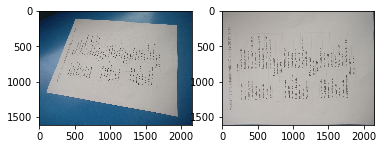

In [11]:
def forward_mapping_with_nearest_nbrs2(source_img, source_points, target_size):
    assert target_size[2]==source_img.shape[2]
    h=target_size[0]-1#nrows (max for i)
    w=target_size[1]-1#ncols (max for j)
    print("h,w:",h,w)
    target_points_xy=np.asarray([[w,h],[0,h],[0.0,0.0],[w,0]]).T
    target_img=np.zeros(target_size)
    secondary_buffer=np.zeros(target_size[:2])
    for pts in target_points_xy.T:
        print(pts,target_img[int(pts[1]),int(pts[0])])

    print("Source Points coordinates:",source_points)
    print("Target Points coordinates:",target_points_xy)
    H=computeH(to_homog(source_points),to_homog(target_points_xy))
    for pts in source_points.T:
        homogpts=to_homog(pts)
        print("Source Point coordinates:",pts)
        outpts=from_homog(np.matmul(H,homogpts))
        print("Corresponding Output point coordinates",(int(outpts[0]),int(outpts[1])))
    for xin in range(source_img.shape[1]):
        for yin in range(source_img.shape[0]):
            inpts=to_homog(np.asarray([xin,yin]))
            (x,y)=from_homog(np.matmul(H,inpts))
            if x<4 or x>target_img.shape[1]-4 or y<4 or y>target_img.shape[0]-4:
                continue
            nbrs=n_nearest_neighbours(y,x,n=8,dist='l2')
            intensity=source_img[yin,xin,:]
            for nbr in nbrs:
                if len(nbr)!=3:
                    print(nbr)
                    continue
                if nbr[1]<0 or nbr[1]>=target_img.shape[0] or nbr[0]<0 or nbr[0]>=target_img.shape[1]:
                    print(nbr)
                    print(x,y)
                    print(xin,yin)
                else:
                    target_img[int(nbr[1]),int(nbr[2])]+=intensity*np.exp(-1*nbr[0])
                    secondary_buffer[int(nbr[1]),int(nbr[2])]+=np.exp(-1*nbr[0])
                
    for yin in range(target_img.shape[0]):
        for xin in range(target_img.shape[1]):
            if secondary_buffer[yin,xin]!=0:
                target_img[yin,xin,:]/=secondary_buffer[yin,xin]
    return target_img

# Use the code below to plot your result
# source_points=np.asarray([[105.0,115.0],[50.0,10.0],[195.0,19.0],[195.0,150.0]]).T.astype(np.float32)
# print("Source Points:",source_points)
# print(source_image.shape)
result = forward_mapping_with_nearest_nbrs2(source_image, source_points, (source_image.shape[0],source_image.shape[1],3)) #Choose appropriate target size
result/=255.0
plt.subplot(1, 2, 1)
plt.imshow(source_image)
plt.subplot(1, 2, 2)
plt.imsave("fwd_mapping_exp_decay_rotated_otherway.png",result)
plt.imshow(result)
plt.show()